In [49]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [50]:
import os
import numpy as np
import numpy.random as rnd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.special import softmax
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.preprocessing import label_binarize
from typing import List, Tuple, TypeVar
from sklearn.metrics.pairwise import rbf_kernel as RBF_PW
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from errors import sECE, accuracy

def ECE(*args, **kwargs):
    return sECE(*args, **kwargs)**.5

def SKCE_vector(kernel, predictions, outcomes):

    def SKCE_vectorized_helper(i,j):
        matrix_kernel = k_g_Xi_g_Xj[i,j] * np.eye(len(predictions[i]))
        return ((diff_outcomes_preds[i] @ matrix_kernel) @ np.array(diff_outcomes_preds[j]).T)

    predictions = np.array(predictions)
    outcomes = np.array(outcomes)
    n = len(outcomes)

    # Compute the kernel matrix for the pair
    k_g_Xi_g_Xj = kernel(predictions, predictions)

    # Compute the difference between unit vectors outcomes and predictions
    diff_outcomes_preds = np.array(outcomes - predictions)

    indices_upper_triangular = np.triu_indices(n, k=1)

    vhelper = np.vectorize(SKCE_vectorized_helper)
    results = vhelper(indices_upper_triangular[0], indices_upper_triangular[1])
    skce = np.sum(results)


    # Divide the SKCE by n over 2
    prefactor = (n* (n-1)) // 2
    skce /= prefactor

    return skce


def transform_outcomes(predictions, outcomes):
    #creates vector for outcomes to match predictions shape
    #outcomes_minus_one = [x - 1 for x in outcomes]
    transformed_outcomes = np.zeros_like(predictions)
    transformed_outcomes[np.arange(len(predictions)), outcomes] = 1
    return transformed_outcomes

# Use the rbf_kernel function from sklearn.metrics.pairwise
def rbf_pw(X, Y=None, length_scale=1.0):
    gamma = 1.0 / (2 * length_scale ** 2)
    return RBF_PW(X, Y, gamma=gamma)
results_dir = 'plots/'

In [51]:
np.random.seed(1)
# amount of classes
C = 100
# amount of val samples
n_val = 10000
# amount of test samples
n_test = 10000
# scaling of the scale matrix to adjust accuracy of the simulation
# lower s -> higher acc; and vice versa
s = .01
# class means (we assume each multivariate mean is a one-hot vector)
eye = np.eye(C)
# sample covariance matrizes from a inv wishart distribution to avoid accidental cherry picking
cov_matrizes = stats.invwishart(scale=eye/s).rvs(size=C)
logits = []

for i in range(C):
    # sample class conditional logits from a multivariate normal dist
    logits.append(stats.multivariate_normal(mean=eye[i], cov=cov_matrizes[i]).rvs(int((n_val+n_test)/C)))

logits = np.concatenate(logits)
labels = []
for logit in logits:
    # since the logits are normal distributed, the probs are logistic normal distributed
    probs = softmax(logit)
    labels.append(np.random.choice(np.arange(C), size=1, p=probs))
    
labels = np.array(labels).flatten()

logits_val = logits[:n_val]
labels_val = labels[:n_val]
logits_test = logits[n_val:]
labels_test = labels[n_val:]

In [52]:
# check for realistic accuracy
acc = accuracy(logits_val, labels_val)
print(acc)

0.8763


In [53]:
def experiment(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        ece_0 = ECE(ls, ys)
        ece_1 = ECE(ls * 1.5, ys)
        ece_2 = ECE(ls * 2.0, ys)
        ece_3 = ECE(ls * 0.75, ys)
        ece_4 = ECE(ls * 0.5, ys)
        
        run = pd.DataFrame({
            'ECE': [ece_0, ece_1, ece_2, ece_3, ece_4],
            'Size': [s, s, s, s, s],
            'Calibration': ['temp = 1', 'temp = 1.5', 'temp = 2.0', 'temp = 0.75', 'temp = 0.5']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results

In [54]:
results_ece = experiment(logits_test, labels_test)

100%|██████████| 3615/3615 [00:38<00:00, 94.57it/s] 


C:\Users\morit\AppData\Local\Temp\ipykernel_19732\2227857395.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration', ci='sd')


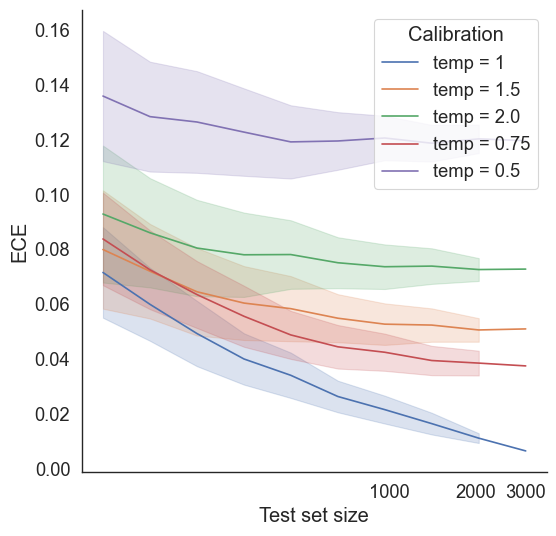

In [55]:
# larger version of Figure 2 in paper
df = results_ece
ticks = [1000, 2000, 3000]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration', ci='sd')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)

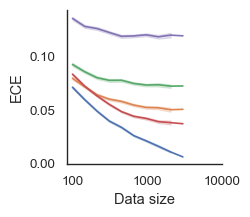

In [56]:
# Figure 2 in paper
df = results_ece
ticks = [100, 1000, 10000]
rc = {'figure.figsize': (2, 2)}
font_scale = 1.1
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Data size')
plot.legend([], [], frameon=False)
sns.despine(left=False, bottom=False)

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plot.figure.savefig(results_dir + 'ece_sim.pdf', bbox_inches = "tight")

In [57]:


def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    def compute_SKCE(s):
        indices = np.random.choice(logits.shape[0], size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        probs = softmax(ls, axis=1)

        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))
        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_2 = SKCE_vector(rbf_pw, probs * 2.0, label_binarize(ys, classes=np.arange(C)))
        skce_3 = SKCE_vector(rbf_pw, probs * 0.75, label_binarize(ys, classes=np.arange(C)))
        skce_4 = SKCE_vector(rbf_pw, probs * 0.5, label_binarize(ys, classes=np.arange(C)))

        return pd.DataFrame({
            'SKCE': [skce_0, skce_1, skce_2, skce_3, skce_4],
            'Size': [s, s, s, s, s],
            'Calibration': ['temp = 1', 'temp = 1.5', 'temp = 2.0', 'temp = 0.75', 'temp = 0.5']
        })

    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['SKCE', 'Size', 'Calibration'])

    runs = Parallel(n_jobs=-1, verbose=5)(delayed(compute_SKCE)(s) for s in repeated_sizes)
    for run in runs:
        results = pd.concat([results, run]).reset_index(drop=True)

    return results


In [58]:
"""def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        probs = softmax(ls, axis=1)

        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))
        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_2 = SKCE_vector(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))

        run = pd.DataFrame({
            'SKCE': [skce_0, skce_1, skce_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results"""


"def experiment_skce(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):\n    np.random.seed(seed)\n    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)\n    # quadratically decrease repetitions\n    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)\n\n    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]\n    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])\n\n    for s in tqdm(repeated_sizes):\n        indices = np.random.choice(n, size=s, replace=False)\n        ls = logits[indices]\n        ys = labels[indices]\n        probs = softmax(ls, axis=1)\n\n        skce_0 = SKCE_vector(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))\n        skce_1 = SKCE_vector(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))\n        skce_2 = SKCE_vector(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))\n\n        run = p

In [59]:
results = experiment_skce(logits_test, labels_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 82.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 97.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 115.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 121.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 125.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 129.2min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 131.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 133.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 134.4min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 135.6min
[Parallel(n_jobs=-1)]: Done 3615 out of 

C:\Users\morit\AppData\Local\Temp\ipykernel_19732\2465346992.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  plot = sns.lineplot(data=df, x='Size', y='SKCE', hue='Calibration', ci='sd')


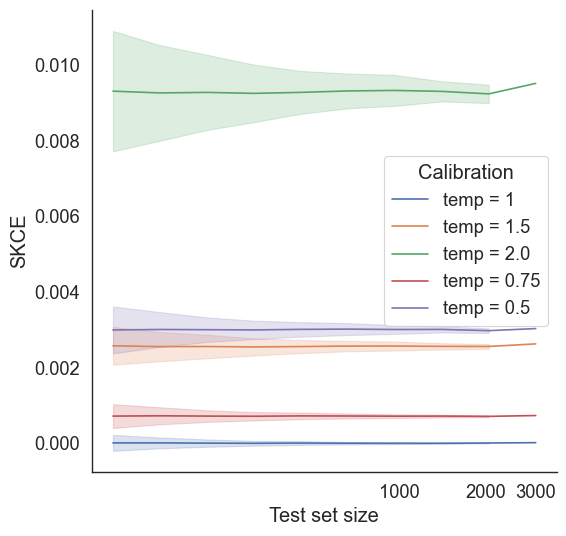

In [60]:

# Plot SKCE instead of ECE
df = results
ticks = [1000, 2000, 3000]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='SKCE', hue='Calibration', ci='sd')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)

#error_bound = 'sd'


In [61]:
fig = plot.get_figure()
fig.savefig("full_exp_2.png")

In [62]:
plot.figure.savefig("alternative_exp_2.png")

In [63]:
logits_test[1]

array([  6.16865645,  -3.71896855,   3.60274014,  -8.40014443,
        -2.12365807,  -3.09834935,  -3.71030244,  -5.17895172,
         7.71281143,   3.23874352,  -7.10569557,  -7.31811924,
         7.14506089, -10.34528478,   2.65143062,   8.83833746,
         3.89711471,   5.88238854,   8.74891129,   0.70534739,
        -9.27539304,   0.0645581 ,   3.65157631,  -6.53494414,
         4.97132355,   1.16101785,   8.22546588,  -0.94426984,
         3.78722188,   0.4769509 ,  -3.92352149,   2.46646277,
        -2.63642674,   6.53868613,  -8.01714624,   5.33455864,
         4.5715781 ,  -4.66692059,  -5.31165443,  -0.33152388,
        -9.26907797,  -7.22138235,   7.83955401,  -1.66240324,
        -3.86114916,  -8.39135492, -13.57209458,  -3.08483352,
        -2.77375712,   7.31221114,   5.41527751,  -1.9604307 ,
         2.34616057,  -4.67754893, -14.86575813,  -9.43159602,
        -3.97101212,  -3.61819392,  -2.0776454 ,   0.19536448,
        -0.87888276,   2.08783213,  10.5381739 ,  -6.92

In [64]:
labels_test[1]

96

In [65]:
transformed = transform_outcomes(logits_test,labels_test)

In [66]:
transformed[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [67]:
label_binarize([labels_test[1]], classes=np.arange(C))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [68]:
results

,SKCE,Size,Calibration
0,0.000015,3000,temp = 1
1,0.002625,3000,temp = 1.5
2,0.009508,3000,temp = 2.0
3,0.000732,3000,temp = 0.75
4,0.003030,3000,temp = 0.5
...,...,...,...
18070,-0.000076,100,temp = 1
18071,0.002695,100,temp = 1.5
18072,0.010225,100,temp = 2.0
18073,0.000569,100,temp = 0.75


In [98]:
# Order for the 'Calibration' values
calibration_order = ['temp = 1', 'temp = 1.5', 'temp = 2.0', 'temp = 0.75', 'temp = 0.5']
calibration_order = ['temp = 0.5', 'temp = 0.75', 'temp = 1', 'temp = 1.5', 'temp = 2.0']


# Combine results for ECE and SKCE
ece_results = results_ece[['ECE', 'Size', 'Calibration']].copy()
ece_results['Metric'] = 'ECE'
ece_results.rename(columns={'ECE': 'Value'}, inplace=True)

skce_results = results[['SKCE', 'Size', 'Calibration']].copy()
skce_results['Metric'] = 'SKCE'
skce_results.rename(columns={'SKCE': 'Value'}, inplace=True)

combined_results = pd.concat([ece_results, skce_results]).reset_index(drop=True)
# Convert the 'Calibration' column to a categorical type with the specified order
combined_results['Calibration'] = pd.Categorical(combined_results['Calibration'], categories=calibration_order, ordered=True)



In [99]:
combined_results

,Value,Size,Calibration,Metric
0,0.006526,3000.0,temp = 1,ECE
1,0.051005,3000.0,temp = 1.5,ECE
2,0.072816,3000.0,temp = 2.0,ECE
3,0.037519,3000.0,temp = 0.75,ECE
4,0.119641,3000.0,temp = 0.5,ECE
...,...,...,...,...
36145,-0.000076,100,temp = 1,SKCE
36146,0.002695,100,temp = 1.5,SKCE
36147,0.010225,100,temp = 2.0,SKCE
36148,0.000569,100,temp = 0.75,SKCE


C:\Users\morit\AppData\Local\Temp\ipykernel_19732\3625840671.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  plot = sns.lineplot(data=combined_results, x='Calibration', y='Value', hue='Metric', ci='sd')
C:\Users\morit\AppData\Local\Temp\ipykernel_19732\3625840671.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(labels=calibration_order, rotation=45) # Set the xtick labels and rotate them for better visibility


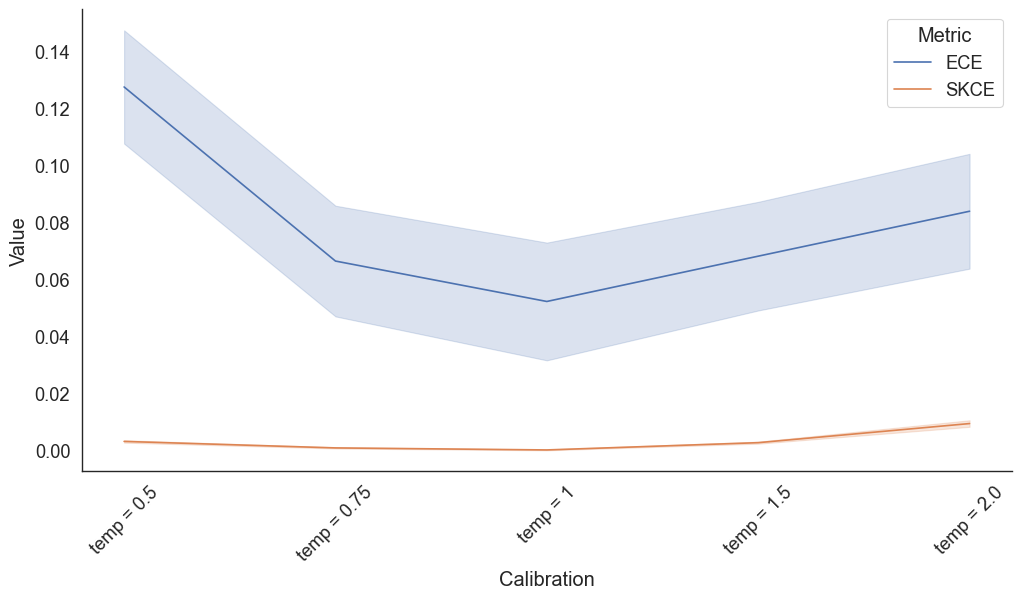

In [100]:
# Plot ECE and SKCE for the same results on the y-axis and the 'Calibration' values on the x-axis
rc = {'figure.figsize': (12, 6)}
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=combined_results, x='Calibration', y='Value', hue='Metric', ci='sd')
plot.set(xlabel='Calibration', ylabel='Value')
plot.set_xticklabels(labels=calibration_order, rotation=45) # Set the xtick labels and rotate them for better visibility
sns.despine(left=False, bottom=False)
plt.show()

In [77]:
plot.figure.savefig("lineplot_ece_skce.png")

C:\Users\morit\AppData\Local\Temp\ipykernel_19732\1507432559.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  plot = sns.barplot(data=combined_results, x='Calibration', y='Value', hue='Metric', ci='sd')


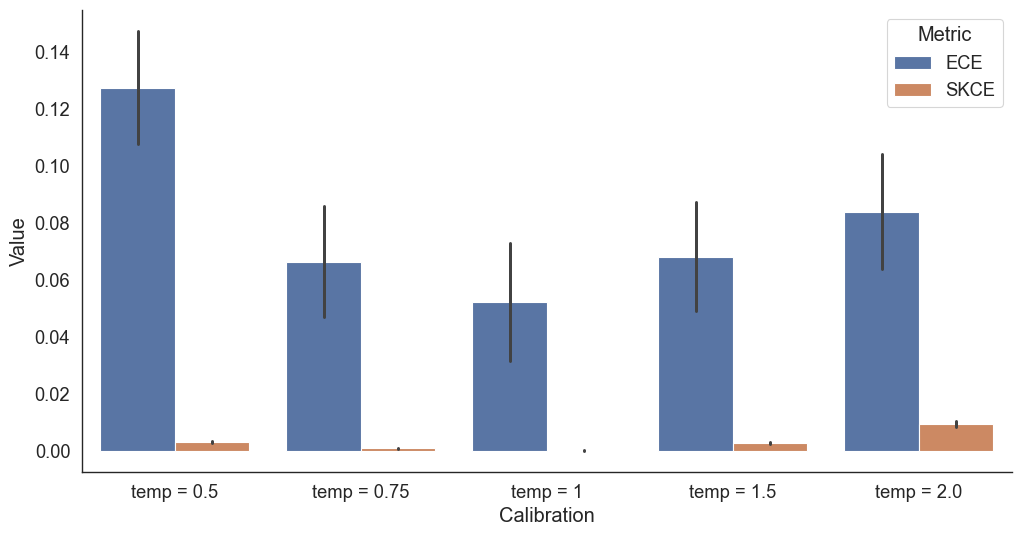

In [101]:
# Plot ECE and SKCE for the same results on the y-axis and the 'Calibration' values on the x-axis
rc = {'figure.figsize': (12, 6)}
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.barplot(data=combined_results, x='Calibration', y='Value', hue='Metric', ci='sd')
plot.set(xlabel='Calibration', ylabel='Value')
sns.despine(left=False, bottom=False)
plt.show()

In [79]:
plot.figure.savefig("barplot_ece_skce.png")

In [80]:
# Extract ECE and SKCE results for the "Bad" category
ece_bad_mean = results_ece[results['Calibration'] == 'Bad']['ECE'].mean()
skce_bad_mean = results[results['Calibration'] == 'Bad']['SKCE'].mean()

# Calculate the scaling factor
scaling_factor = ece_bad_mean / skce_bad_mean

print(scaling_factor)

nan


In [102]:
scaling_factor = 25

In [103]:
scaled_skce_results = skce_results.copy()
# Scale the SKCE values by the scaling factor
scaled_skce_results['Value'] = scaled_skce_results['Value'] * scaling_factor

# Combine ECE and SKCE results
combined_results = pd.concat([ece_results, scaled_skce_results]).reset_index(drop=True)

# Convert the 'Calibration' column to a categorical type with the specified order
combined_results['Calibration'] = pd.Categorical(combined_results['Calibration'], categories=calibration_order, ordered=True)


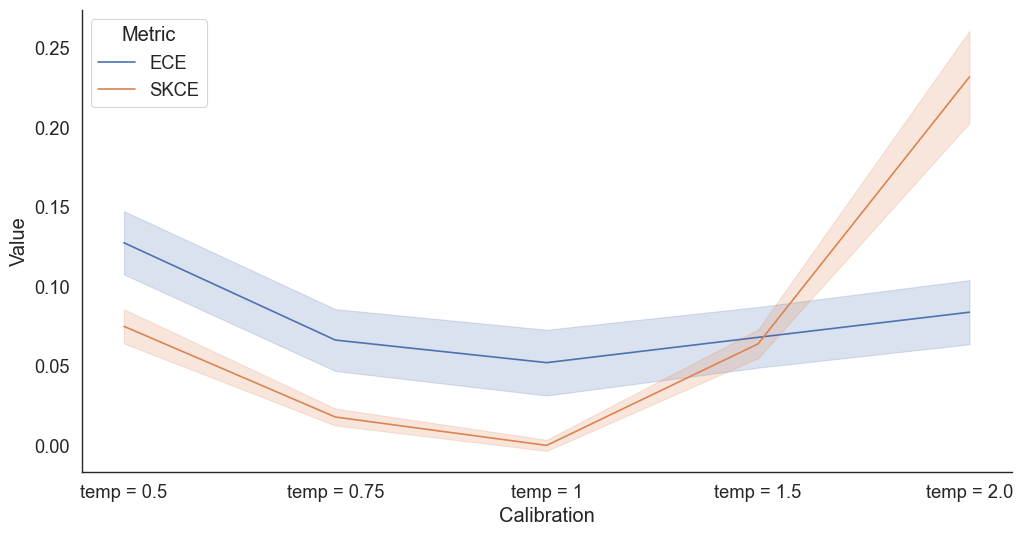

In [109]:

# Plot ECE and SKCE with standard deviation on the y-axis and the 'Calibration' values on the x-axis
rc = {'figure.figsize': (12, 6)}
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=combined_results, x='Calibration', y='Value', hue='Metric', errorbar='sd')
plot.set(xlabel='Calibration', ylabel='Value')
sns.despine(left=False, bottom=False)
plt.show()

In [84]:
def compute_SKCE_kernel(kernel, s, logits, labels):
    indices = np.random.choice(logits.shape[0], size=s, replace=False)
    ls = logits[indices]
    ys = labels[indices]
    probs = softmax(ls, axis=1)

    skce_0 = SKCE_vector(kernel, probs, label_binarize(ys, classes=np.arange(C)))
    skce_1 = SKCE_vector(kernel, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
    skce_2 = SKCE_vector(kernel, probs * 2.0, label_binarize(ys, classes=np.arange(C)))

    return pd.DataFrame({
        'SKCE': [skce_0, skce_1, skce_2],
        'Size': [s, s, s],
        'Calibration': ['Perfect', 'Mediocre', 'Bad']
    })

In [85]:
def experiment_skce_kernels(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)
    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]

    # Store results for all kernels
    all_results = []

    for kernel_name, kernel_func in kernels.items():
        print(f"Computing SKCE for kernel: {kernel_name}")
        results = pd.DataFrame(columns=['SKCE', 'Size', 'Calibration', 'Kernel'])

        # Run the experiment in parallel for each size
        runs = Parallel(n_jobs=-1, verbose=5)(delayed(compute_SKCE_kernel)(kernel_func, s, logits, labels) for s in repeated_sizes)

        # Aggregate results
        for run in runs:
            run['Kernel'] = kernel_name
            results = pd.concat([results, run]).reset_index(drop=True)

        all_results.append(results)

    # Concatenate all results
    final_results = pd.concat(all_results).reset_index(drop=True)
    return final_results

In [86]:
from sklearn.metrics.pairwise import polynomial_kernel, sigmoid_kernel, linear_kernel, laplacian_kernel, cosine_similarity


In [87]:
# Define kernels
kernels = {
    'Polynomial': polynomial_kernel,
    'Sigmoid': sigmoid_kernel,
    'Linear': linear_kernel,
    'Laplacian': laplacian_kernel,
    'Cosine': cosine_similarity
}

In [88]:
kernel_comparison_results = experiment_skce_kernels(logits_test, labels_test)

Computing SKCE for kernel: Polynomial


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 58.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 72.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 77.3min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 78.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 80.5min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | el

Computing SKCE for kernel: Sigmoid


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 59.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 69.9min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 73.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 76.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 78.3min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 79.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 80.8min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 81.5min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 82.2min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | el

Computing SKCE for kernel: Linear


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 65.6min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 76.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 78.8min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 82.0min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 82.7min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | el

Computing SKCE for kernel: Laplacian


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 65.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 74.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 76.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 79.0min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 80.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 81.5min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 82.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 82.9min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | el

Computing SKCE for kernel: Cosine


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 64.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 77.9min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 79.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 80.4min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | el

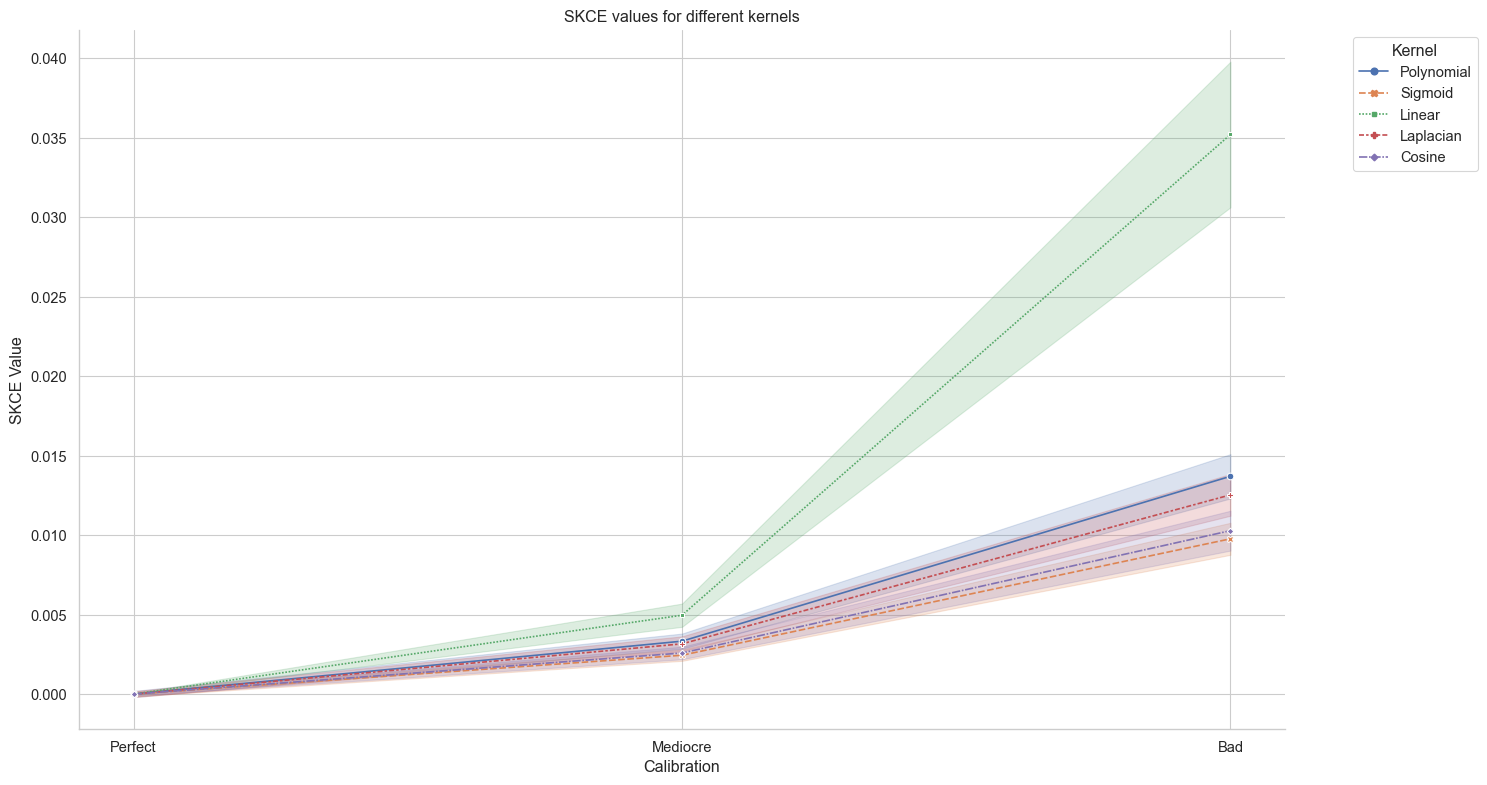

In [89]:
rc = {'figure.figsize': (15, 8)}
sns.set(rc=rc, font_scale=1.2, context='paper')
sns.set_style("whitegrid")

# Create a line plot with Calibration on the x-axis, SKCE on the y-axis, and the Kernel type represented by different lines (hues)
plot = sns.lineplot(data=kernel_comparison_results, x='Calibration', y='SKCE', hue='Kernel', errorbar='sd', markers=True, style='Kernel')

plot.set_title('SKCE values for different kernels')
plot.set_xlabel('Calibration')
plot.set_ylabel('SKCE Value')
plt.legend(title='Kernel', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [97]:
kernel_comparison_results

,SKCE,Size,Calibration,Kernel
0,0.000020,3000,Perfect,Polynomial
1,0.003436,3000,Mediocre,Polynomial
2,0.013974,3000,Bad,Polynomial
3,0.000035,2056,Perfect,Polynomial
4,0.003351,2056,Mediocre,Polynomial
...,...,...,...,...
54220,0.004230,100,Mediocre,Cosine
54221,0.015655,100,Bad,Cosine
54222,0.000170,100,Perfect,Cosine
54223,0.003168,100,Mediocre,Cosine


In [90]:
plot.figure.savefig("comparing_kernels.png")

In [91]:
filtered_kernel_comparison_results = kernel_comparison_results[kernel_comparison_results['Kernel'] != 'Linear']

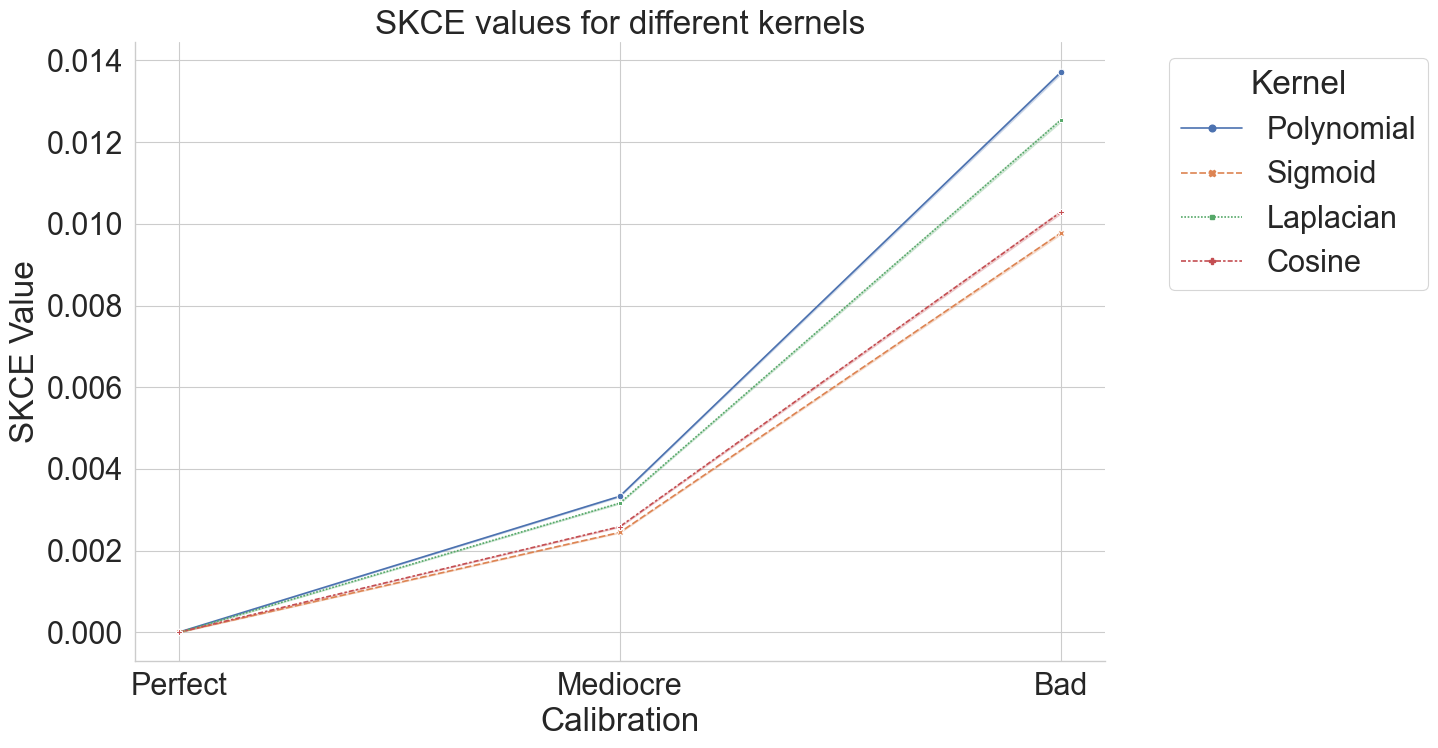

In [111]:
rc = {'figure.figsize': (15, 8)}
sns.set(rc=rc, font_scale=2.5, context='paper')
sns.set_style("whitegrid")

# Create a line plot with Calibration on the x-axis, SKCE on the y-axis, and the Kernel type represented by different lines (hues)
plot = sns.lineplot(data=filtered_kernel_comparison_results, x='Calibration', y='SKCE', hue='Kernel', markers=True, style='Kernel')

plot.set_title('SKCE values for different kernels')
plot.set_xlabel('Calibration')
plot.set_ylabel('SKCE Value')
plt.legend(title='Kernel', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [93]:
plot.figure.savefig("filtered_comparing_kernels.png")

In [94]:
def compute_ece_bins(s, logits, labels, bins):
    indices = np.random.choice(logits.shape[0], size=s, replace=False)
    ls = logits[indices]
    ys = labels[indices]

    ece_value = ECE(ls, ys, bins=bins)

    return pd.DataFrame({
        'Value': [ece_value],
        'Size': [s],
        'Bins': [bins]
    })

def experiment_ece_bins(logits, labels, start_rep=1000, start_n=100, n=3000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)
    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]

    # Define bins for the experiment
    bin_sizes = [1, 5, 10, 15, 20, 25]

    all_results = []

    for bins in bin_sizes:
        print(f"Computing ECE for bin size: {bins}")
        results = pd.DataFrame(columns=['Value', 'Size', 'Bins'])

        # Run the experiment in parallel for each size
        runs = Parallel(n_jobs=-1, verbose=5)(delayed(compute_ece_bins)(s, logits, labels, bins) for s in repeated_sizes)

        # Aggregate results
        for run in runs:
            results = pd.concat([results, run]).reset_index(drop=True)

        all_results.append(results)

    # Concatenate all results
    final_results = pd.concat(all_results).reset_index(drop=True)
    return final_results

def plot_ece_bins_comparison(results):
    rc = {'figure.figsize': (15, 8)}
    sns.set(rc=rc, font_scale=2, context='paper')
    sns.set_style("whitegrid")

    # Create a line plot with Bins on the x-axis and Value on the y-axis
    plot = sns.lineplot(data=results, x='Bins', y='Value', errorbar='sd', markers=True)

    plot.set_title('ECE for different bin amounts')
    plot.set_xlabel('Number of Bins')
    plot.set_ylabel('ECE Value')
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    plt.show()


In [95]:
ece_bins_results = experiment_ece_bins(logits_test, labels_test)

Computing ECE for bin size: 1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3544 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    8.4s finished


Computing ECE for bin size: 5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    2.7s finished


Computing ECE for bin size: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    2.7s finished


Computing ECE for bin size: 15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    2.9s finished


Computing ECE for bin size: 20


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    2.8s finished


Computing ECE for bin size: 25


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3615 out of 3615 | elapsed:    3.0s finished


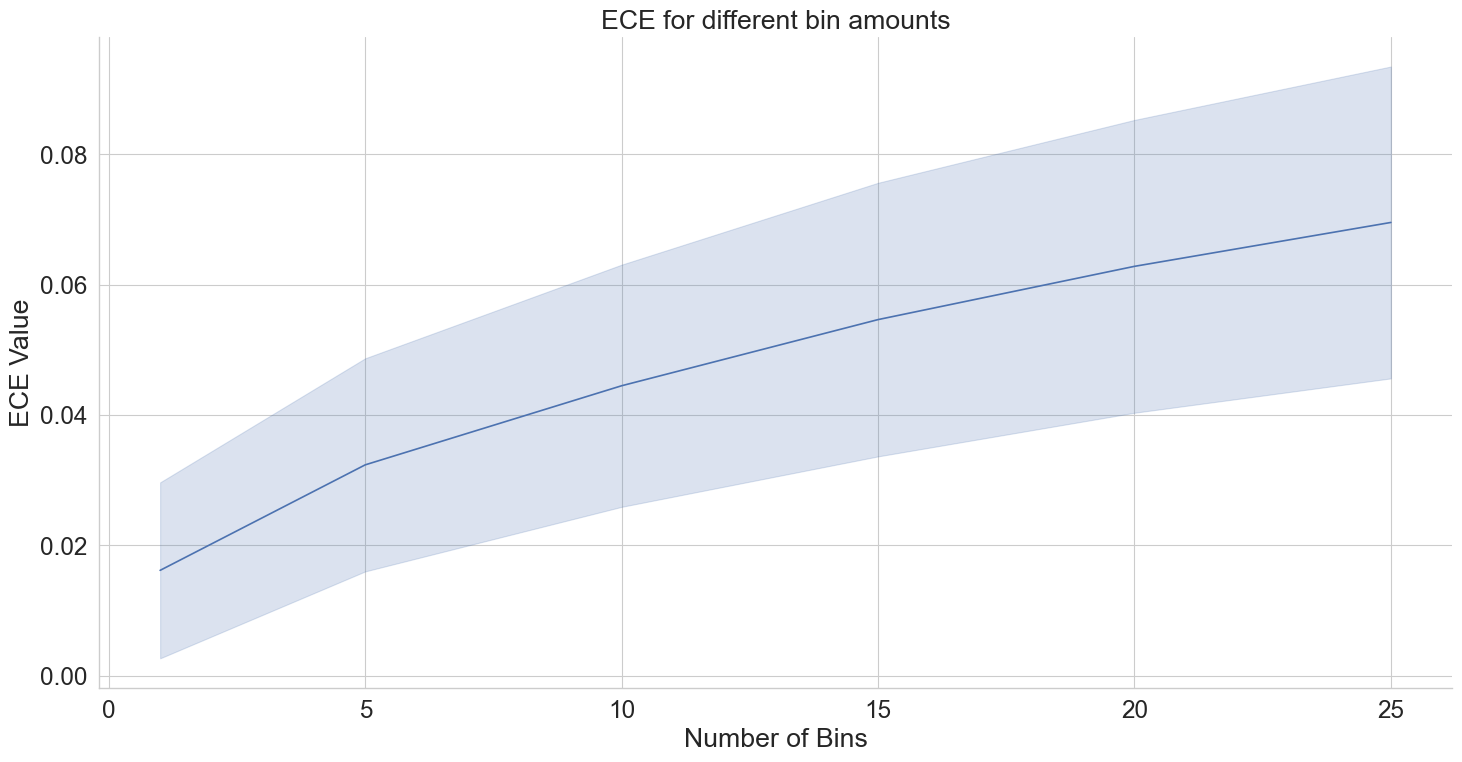

In [96]:
plot_ece_bins_comparison(ece_bins_results)